In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from bs4 import BeautifulSoup
import pandas as pd
import os

html_tables = {}

# For every table in the datasets folder...
for table_name in os.listdir('/content/input'):
    #this is the path to the file. Don't touch!
    table_path = f'/content/input/{table_name}'

    # Open as a python file in read-only mode
    table_file = open(table_path, 'r')

    # Read the contents of the file into 'html'
    html = BeautifulSoup(open(table_path, 'r'))

    # Find 'news-table' in the Soup and load it into 'html_table'
    html_table = html.find(id='news-table')

    # Add the table to our dictionary
    html_tables[table_name] = html_table

print('ok!')

ok!


In [ ]:
fb = html_tables['fb_05ene.html']
# Get all the table rows tagged in HTML with <tr> into 'tesla_tr'
fb_tr = fb.findAll('tr')

# For each row...

for i, table_row in enumerate(fb_tr):
    # Read the text of the element 'a' into 'link_text'
    link_text = table_row.a.get_text()
    # Read the text of the element 'td' into 'data_text'
    data_text = table_row.td.get_text()
    # Print the count
    print(f'{i}:')
    # Print the contents of 'link_text' and 'data_text'
    print(link_text)
    print(data_text)
    # The following exits the loop after three rows to prevent spamming the notebook, do not touch
    if i == 3:
        break

0:
Facebook, Apple, Netflix, Amazon and Alphabet Power Friday Gains
Jan-04-19 06:22PM  
1:
Earnings Reports for the Week of Jan. 7-11 (BBBY, KBH)
05:15PM  
2:
COLUMN-Commentary: 2019 will be the year of more state control
04:55PM  
3:
3 Tech Trends to Watch in 2019
04:53PM  


In [ ]:
parsed_news = []
# Iterate through the news
for file_name, news_table in html_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):

        # Read the text from the tr tag into text
        text = x.get_text()

        # Split the text in the td tag into a list
        date_scrape = x.td.text.split()
        headline = x.a.text

        # If the length of 'date_scrape' is 1, load 'time' as the only element
        # If not, load 'date' as the 1st element and 'time' as the second

        if len(date_scrape) == 1:
            time = date_scrape[0]

        else:
            date = date_scrape[0]
            time = date_scrape[1]

        # Extract the ticker from the file name, get the string up to the 1st '_'
        ticker = file_name.split('_')[0]

        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, headline])

print(parsed_news[:10])

[['tsla', 'Nov-26-18', '01:25PM', 'Tesla was weeks from dying earlier this year, Elon Musk says'], ['tsla', 'Nov-26-18', '01:08PM', "Elon Musk Says Tesla Was 'Close to Death' During Model 3 Ramp-Up"], ['tsla', 'Nov-26-18', '01:07PM', 'Tesla Almost Died Earlier This Year, Says Elon Musk'], ['tsla', 'Nov-26-18', '01:00PM', 'Elon Musk Said Tesla Almost Died  and the Stock Market Shrugged'], ['tsla', 'Nov-26-18', '12:36PM', 'Elon Musk Admits Tesla Was Near Death This Year'], ['tsla', 'Nov-26-18', '11:54AM', 'Whatever Doesnt Kill Tesla Makes It Stranger'], ['tsla', 'Nov-26-18', '10:21AM', 'Elon Musk: Tesla was weeks away from failure'], ['tsla', 'Nov-26-18', '09:30AM', 'Company News For Nov 26, 2018'], ['tsla', 'Nov-26-18', '08:30AM', 'Musk Admits Tesla Was Close To Collapsing Earlier This Year Amid Model 3 Ramp'], ['tsla', 'Nov-26-18', '08:20AM', 'What Tesla did for luxury cars, Rivian wants to do for pickups']]


In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# New words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()
# Update the lexicon
vader.lexicon.update(new_words)

print('ok!')

ok!


In [ ]:
columns = ['ticker', 'date', 'time', 'headline']
# Convert the list of lists into a DataFrame
scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores
scores = scored_news['headline'].apply(vader.polarity_scores)

# Convert the list of dicts into a DataFrame
scores_df = pd.DataFrame.from_records(scores)

# Join the DataFrames
scored_news = scored_news.join(scores_df)

# Convert the date column from string to datetime
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date
print(scored_news.head())

  ticker        date     time  \
0   tsla  2018-11-26  01:25PM   
1   tsla  2018-11-26  01:08PM   
2   tsla  2018-11-26  01:07PM   
3   tsla  2018-11-26  01:00PM   
4   tsla  2018-11-26  12:36PM   

                                            headline    neg    neu    pos  \
0  Tesla was weeks from dying earlier this year, ...  0.000  1.000  0.000   
1  Elon Musk Says Tesla Was 'Close to Death' Duri...  0.281  0.719  0.000   
2  Tesla Almost Died Earlier This Year, Says Elon...  0.292  0.708  0.000   
3  Elon Musk Said Tesla Almost Died  and the Stoc...  0.249  0.751  0.000   
4    Elon Musk Admits Tesla Was Near Death This Year  0.298  0.534  0.168   

   compound  
0    0.0000  
1   -0.5994  
2   -0.5118  
3   -0.5118  
4   -0.4019  


<Axes: xlabel='date'>

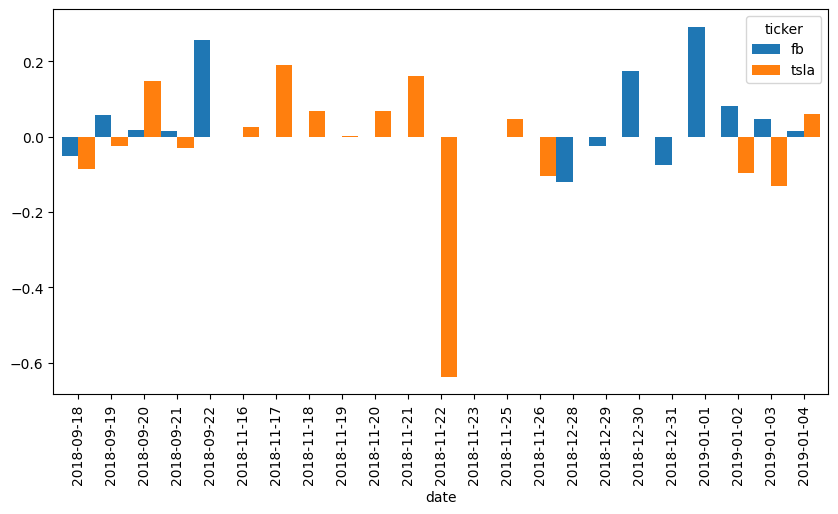

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Group by date and ticker columns from scored_news and calculate the mean
mean_c = scored_news.groupby(['date', 'ticker']).mean()

# Unstack the column ticker
mean_c = mean_c.unstack('ticker')

# Get the cross-section of compound in the 'columns' axis
mean_c = mean_c.xs('compound', axis='columns')
# Plot a bar chart with pandas

mean_c.plot(kind='bar', figsize=(10,5), width=1)

In [ ]:
num_news_before = scored_news['headline'].count()

# Drop duplicates based on ticker and headline
scored_news_clean = scored_news.drop_duplicates(subset=['ticker','headline'])

# Count number of headlines after dropping duplicates
num_news_after = scored_news_clean['headline'].count()

# Print before and after numbers to get an idea of how we did
print(f"Before we had {num_news_before} headlines, now we have {num_news_after}")

Before we had 500 headlines, now we have 476


In [ ]:
import pandas as pd

# Assuming your DataFrame is named scored_news_clean
# Convert 'date' column to datetime
scored_news['date'] = pd.to_datetime(scored_news['date'])

# Set the index to ['ticker', 'date']
single_day = scored_news.set_index(['ticker', 'date'])

# Cross-section the 'fb' row
single_day = single_day.xs('fb', level='ticker')

# Select the 3rd of January of 2019
single_day = single_day.loc[('2019-01-03')]

# Convert the datetime string to just the time
single_day['time'] = pd.to_datetime(single_day['time']).dt.time

# Set the index to 'time'
single_day = single_day.set_index('time')

# Sort the DataFrame by the index
single_day = single_day.sort_index()

print(single_day.info())





<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 06:00:00 to 22:59:00
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   headline  20 non-null     object 
 1   neg       20 non-null     float64
 2   neu       20 non-null     float64
 3   pos       20 non-null     float64
 4   compound  20 non-null     float64
dtypes: float64(4), object(1)
memory usage: 960.0+ bytes
None


<Axes: xlabel='time'>

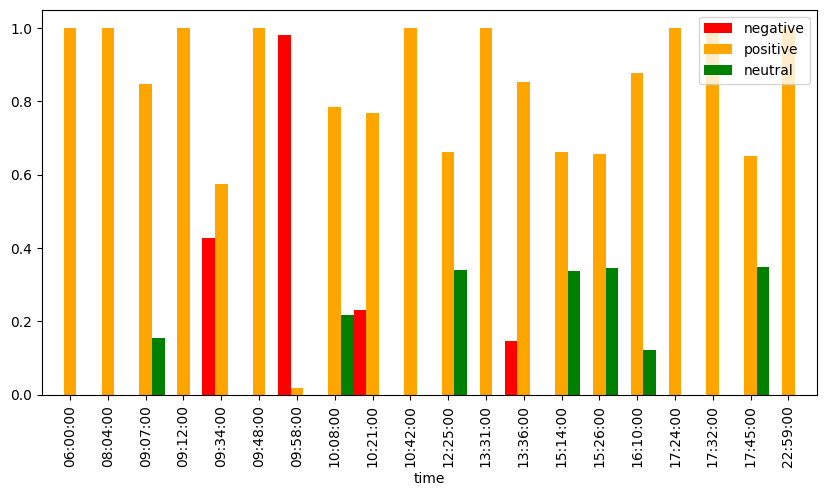

In [ ]:
TITLE = "Positive, negative and neutral sentiment for FB on 2019-01-03"
COLORS = ["red", "orange", "green"]

# Drop the columns that aren't useful for the plot
plot_day = single_day.drop(['headline', 'compound'], axis=1)

# Change the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative', 'positive', 'neutral']

# Plot a stacked bar chart
plot_day.plot(kind='bar', color=COLORS, figsize=(10,5), width=1)

In [ ]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Assuming 'df' is your DataFrame containing the dataset

# Initialize VADER sentiment analyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
df=scored_news
# Perform sentiment analysis and assign sentiment labels
df['sentiment'] = df['headline'].apply(lambda x: 'pos' if sid.polarity_scores(x)['compound'] > 0 else ('neg' if sid.polarity_scores(x)['compound'] < 0 else 'neu'))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['headline'], df['sentiment'], test_size=0.2, random_state=42)

# Convert headlines to numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train a Logistic Regression classifier
clf = LogisticRegression(max_iter=1000)  # You can use other classifiers as well
clf.fit(X_train_tfidf, y_train)

# Predict sentiment on the test set
y_pred = clf.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Accuracy: 0.65


In [ ]:
# Save DataFrame as CSV file
df.to_csv('dataset1.csv', index=False)
